In [1]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import seaborn as sns

import vak

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [3]:
REPO_ROOT = Path('~/Documents/repos/coding/birdsong/tweetynet').expanduser().resolve()
BFSONGREPO_RESULTS_ROOT = REPO_ROOT.joinpath('results/BFSongRepository').expanduser().resolve()

get paths to all .csv files created by script `eval_without_and_with_output_transforms.py`

In [4]:
csvs = sorted(BFSONGREPO_RESULTS_ROOT.glob('*.csv'))

munge all the csvs into one big pandas `DataFrame`, adding columns "bird ID" and "day", where "day" is just 

In [5]:
METRICS = [
    'acc',
    'acc_majority_vote',
    'acc_min_dur_maj_vote',
    'acc_min_segment_dur',
    'levenshtein',
    'levenshtein_majority_vote',
    'levenshtein_min_dur_maj_vote',
    'levenshtein_min_segment_dur',
    'segment_error_rate',
    'segment_error_rate_majority_vote',
    'segment_error_rate_min_dur_maj_vote',
    'segment_error_rate_min_segment_dur',
]

records = defaultdict(list)

for csv in csvs:
    bird_id = csv.name.split('.')[0]

    df = pd.read_csv(csv)
    for count, date in enumerate(df['date'].unique()):
        day = count + 1
        records['date'].append(date)
        records['day'].append(day)
        records['bird_id'].append(bird_id)

        df_date = df[df['date'] == date]
        for metric in METRICS:
            mn_metric = df_date[metric].mean()
            records[f'mean_{metric}'].append(mn_metric)

data = pd.DataFrame.from_records(records)

add duration for each data by finding corresponding dataset .csv, computing duration, and adding to column

In [6]:
duration_col = []
date_col = []  # use to test that we got the order of duration correct

for bird_id in data['bird_id'].unique():
    # get eval csv files for this bird id
    eval_dataset_csvs = sorted(BFSONGREPO_RESULTS_ROOT.joinpath(f'{bird_id}/eval').glob('*.csv'))
    # and then get their duration and the date
    duration_date_tuples = []
    for eval_dataset_csv in eval_dataset_csvs:
        df_eval = pd.read_csv(eval_dataset_csv)
        duration = vak.io.dataframe.split_dur(df_eval, 'test')
        date_from_df = Path(df_eval['audio_path'][0]).parents[1].name
        date_from_df = int(date_from_df)  # type for date column is int. Yes I know this is not a great idea
        duration_date_tuples.append(
            (duration, date_from_df)
        )

    # now add duration by finding corresponding date
    for date in data[data['bird_id'] == bird_id]['date'].unique():
        dur_date_tup = [dur_date_tup for dur_date_tup in duration_date_tuples if dur_date_tup[1] == date]
        assert len(dur_date_tup) == 1, 'more than one date matched'
        dur_date_tup = dur_date_tup[0]
        duration_col.append(dur_date_tup[0])
        date_col.append(dur_date_tup[1])

# test dates are in same order as in DataFrame. If test passes, we can just add duration_col as is.
date_col = np.asarray(date_col)
assert np.all(np.equal(date_col, data['date'].values))

duration_col = np.asarray(duration_col)
data['test_set_duration'] = duration_col

data['test_set_duration_min'] = data['test_set_duration'] / 60

convert (framewise) accuracy to error, i.e. add columns with (1 - accuracy).  
Multiple columns because of measuring accuracy without and with the transformations applied to the network outputs.

In [7]:
METRICS

['acc',
 'acc_majority_vote',
 'acc_min_dur_maj_vote',
 'acc_min_segment_dur',
 'levenshtein',
 'levenshtein_majority_vote',
 'levenshtein_min_dur_maj_vote',
 'levenshtein_min_segment_dur',
 'segment_error_rate',
 'segment_error_rate_majority_vote',
 'segment_error_rate_min_dur_maj_vote',
 'segment_error_rate_min_segment_dur']

In [8]:
for metric in METRICS:
    if 'acc' in metric:
        err_name = metric.replace('acc', 'err')
        data[f'mean_{err_name}'] = 1 - data[f'mean_{metric}']

Check that we have a sane looking result before plotting

In [9]:
data[data['bird_id'] == 'or60yw70']

,bird_id,date,day,mean_acc,mean_acc_majority_vote,mean_acc_min_dur_maj_vote,mean_acc_min_segment_dur,mean_levenshtein,mean_levenshtein_majority_vote,mean_levenshtein_min_dur_maj_vote,...,mean_segment_error_rate,mean_segment_error_rate_majority_vote,mean_segment_error_rate_min_dur_maj_vote,mean_segment_error_rate_min_segment_dur,test_set_duration,test_set_duration_min,mean_err,mean_err_majority_vote,mean_err_min_dur_maj_vote,mean_err_min_segment_dur
12,or60yw70,92712,1,0.975120,0.976455,0.976824,0.976824,8.784615,2.476923,1.138462,...,0.110552,0.037118,0.017398,0.017398,977.982,16.299700,0.024880,0.023545,0.023176,0.023176
13,or60yw70,92812,2,0.976149,0.977583,0.977807,0.977807,7.116667,1.950000,0.800000,...,0.100051,0.027342,0.015219,0.015219,759.644,12.660733,0.023851,0.022417,0.022193,0.022193
14,or60yw70,92912,3,0.979027,0.980370,0.980697,0.980697,7.673684,2.052632,0.842105,...,0.105894,0.031186,0.012146,0.012146,1360.548,22.675800,0.020973,0.019630,0.019303,0.019303
15,or60yw70,93012,4,0.976686,0.978430,0.978716,0.978716,7.468354,1.962025,0.822785,...,0.106126,0.029741,0.012542,0.012542,1044.610,17.410167,0.023314,0.021570,0.021284,0.021284
16,or60yw70,100112,5,0.920035,0.924780,0.922829,0.922829,22.846154,8.948718,6.717949,...,0.315383,0.138630,0.091870,0.091870,500.218,8.336967,0.079965,0.075220,0.077171,0.077171


### figure, version 1
Plot figure

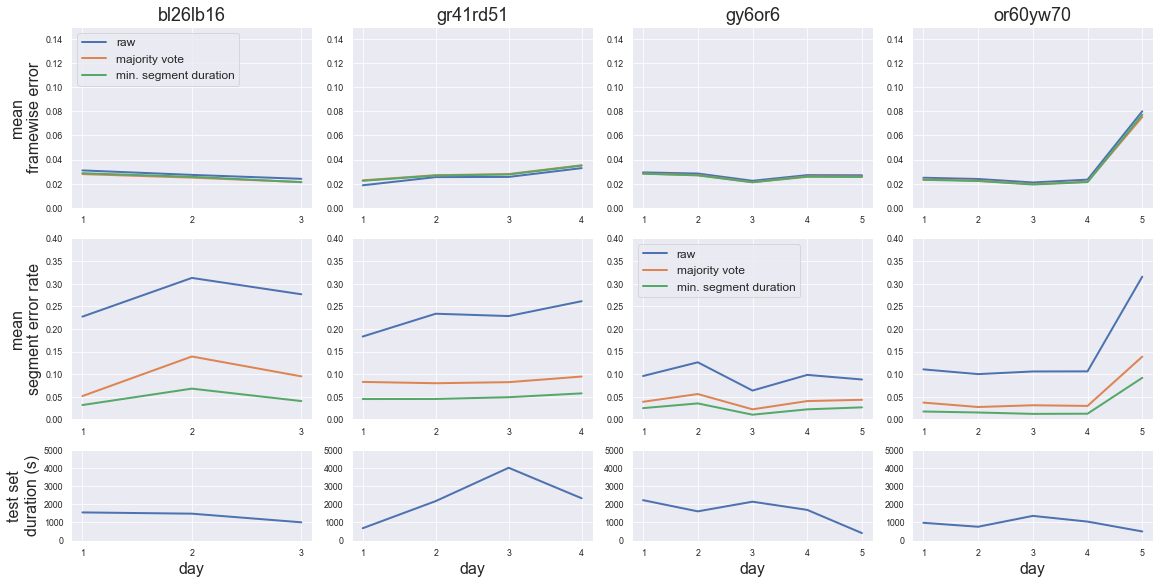

In [10]:
SAVE_FIG = True

sns.set("paper")

bird_ids = data['bird_id'].unique()
n_bird_ids = len(bird_ids)

ERR_METRICS = [
         'err',
         'err_majority_vote',
         # 'err_min_dur_maj_vote',
         'err_min_segment_dur',
]

SEG_ERR_RATE_METRICS = [
         'segment_error_rate',
         'segment_error_rate_majority_vote',
         # 'segment_error_rate_min_dur_maj_vote',
         'segment_error_rate_min_segment_dur',
]

METRIC_LISTS = (ERR_METRICS, SEG_ERR_RATE_METRICS, ['test_set_duration'])

nrows, ncols = len(METRIC_LISTS), n_bird_ids
FIGSIZE = (16, 8)
# fig, ax = plt.subplots(n_row, n_col, figsize=FIGSIZE)

fig = plt.figure(constrained_layout=True, figsize=FIGSIZE)
widths = [1, 1, 1, 1]
heights = [1, 1, 0.5]
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths, height_ratios=heights)
ax = []
for row, height in enumerate(heights):
    ax_col = []
    for col, width in enumerate(widths):
        ax_col.append(
            fig.add_subplot(spec[row, col])
        )
    ax.append(ax_col)
ax = np.array(ax)

for row, metric_list in enumerate(METRIC_LISTS):
    for col, bird_id in enumerate(bird_ids):
        for metric in metric_list:
            if metric.endswith('majority_vote'):
                label = 'majority vote'
            elif metric.endswith('min_dur_maj_vote'):
                label = 'min. segment duration +\nmajority vote'
            elif metric.endswith('min_segment_dur'):
                label = 'min. segment duration'
            else:
                label = 'raw'

            bird_data = data[data['bird_id'] == bird_id]

            if metric != 'test_set_duration':
                y_name = f'mean_{metric}'
            else:
                y_name = metric

            sns.lineplot(x='day', y=y_name, data=bird_data, ax=ax[row, col], label=label, legend=False, linewidth=2)
            ax[row, col].set_ylabel('')
            ax[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))

            if row == 0:
                ax[row, col].set_title(bird_id, fontsize=18)
                ax[row, col].set_xlabel('')
            elif row == 1:
                ax[row, col].set_xlabel('')
            elif row == 2:
                ax[row, col].set_xlabel('day', fontsize=16)
                
for ax_ in ax[0]:
    ax_.set_ylim([0., 0.15])
for ax_ in ax[1]:
    ax_.set_ylim([0., 0.4])
for ax_ in ax[2]:
    ax_.set_ylim([0., 5000])
    
ax[0, 0].set_ylabel('mean\nframewise error', fontsize=16)
ax[1, 0].set_ylabel('mean\nsegment error rate', fontsize=16)
ax[2, 0].set_ylabel('test set\nduration (s)', fontsize=16)

ax[0, 0].legend(loc='upper left', fontsize=12)
ax[1, 2].legend(loc='upper left', fontsize=12);

if SAVE_FIG:
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig5/fig5-error-across-days.png')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig5/fig5-error-across-days.svg')
    )

### figure, version 2
with all birds on one axis

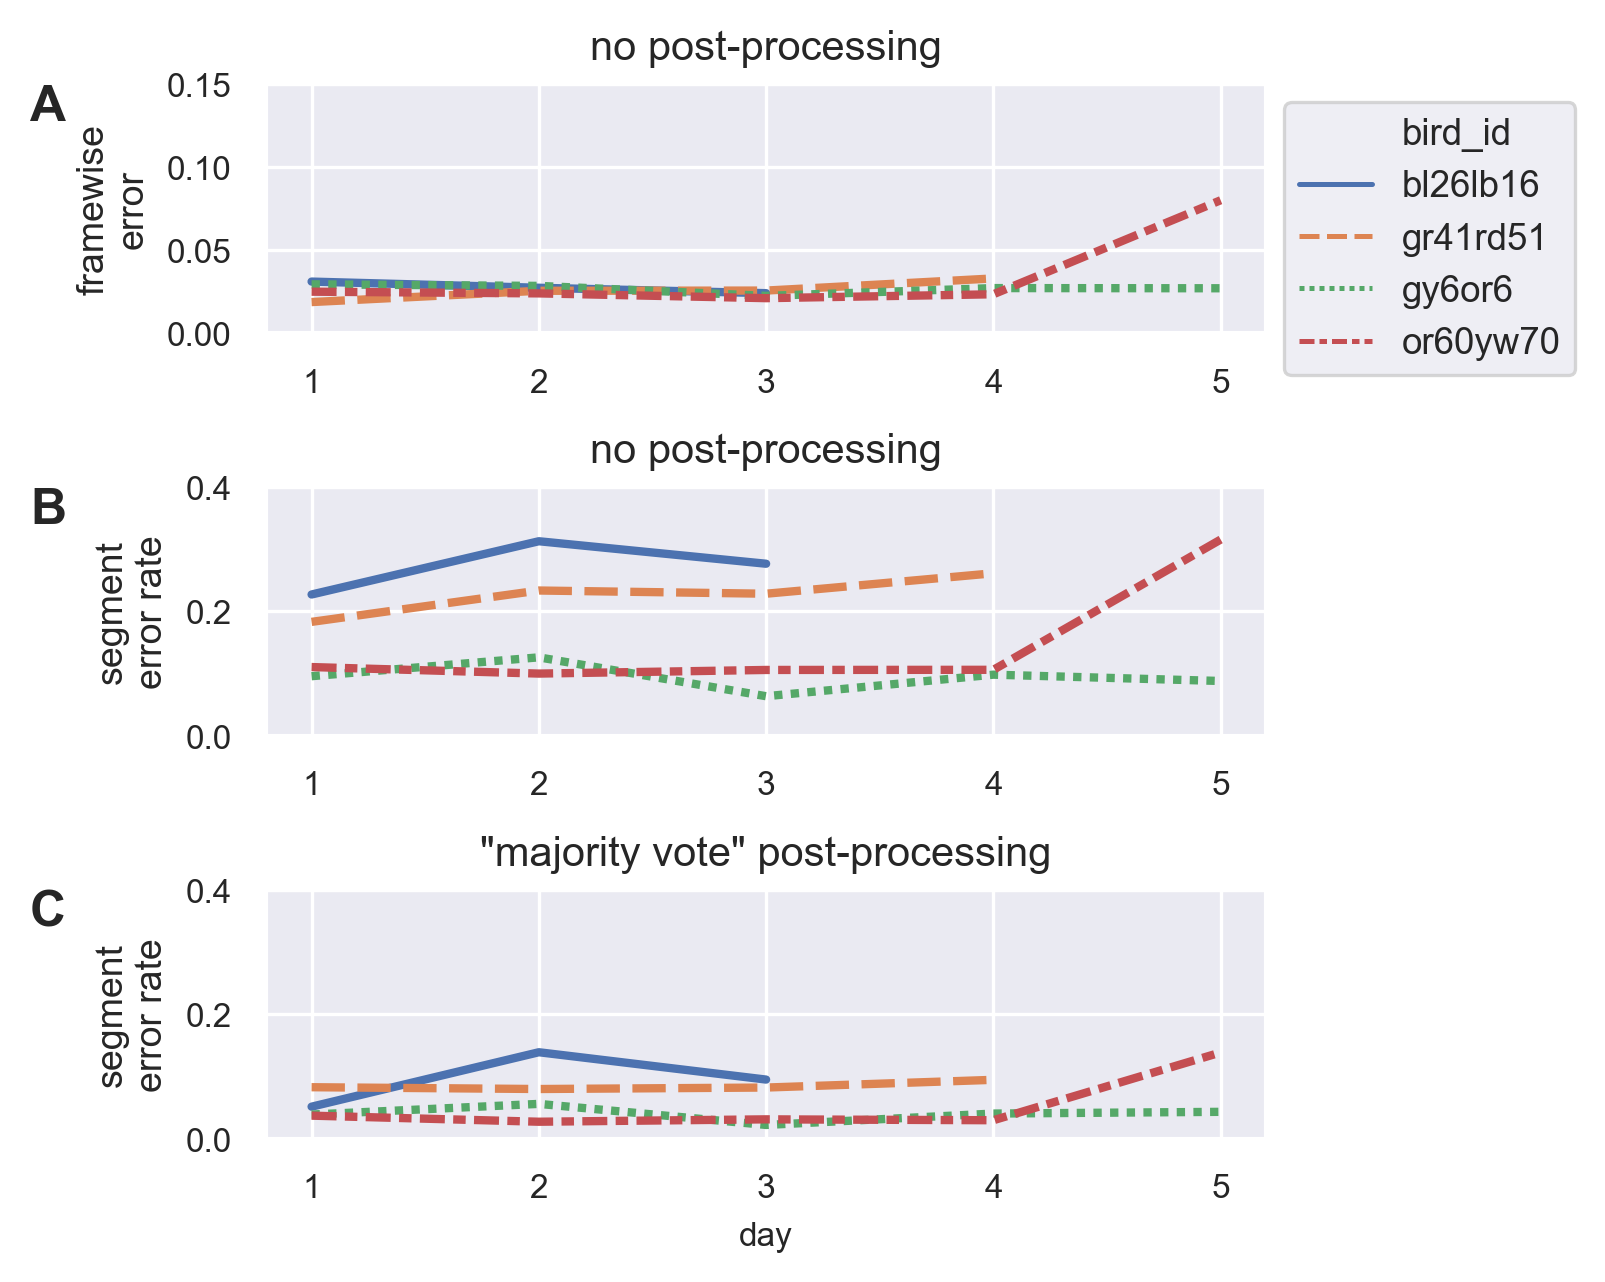

In [31]:
SAVE_FIG = True

sns.set("paper")

bird_ids = data['bird_id'].unique()
n_bird_ids = len(bird_ids)

# only show metrics for days up to and including MAX_DAY
MAX_DAY = 5

ERR_METRICS = [
         'err',
]

SEG_ERR_RATE_METRICS = [
    'segment_error_rate',
    'segment_error_rate_majority_vote'
]

METRIC_LISTS = (*ERR_METRICS, 
                *SEG_ERR_RATE_METRICS,
                # ['test_set_duration']
               )

nrows, ncols = len(METRIC_LISTS), 1
FIGSIZE = (5.2, 4.16)
DPI = 300

fig = plt.figure(constrained_layout=True, figsize=FIGSIZE, dpi=DPI)
widths = [1]
heights = [1, 1, 1]
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths, height_ratios=heights)

ax = []
for row, height in enumerate(heights):
    for col, width in enumerate(widths):
        ax.append(
            fig.add_subplot(spec[row, col])
        )

for ax_ in ax:
    ax_.tick_params(labelsize=8)
ax = np.array(ax)

for ax_ind, metric in enumerate(METRIC_LISTS):   
    metric_data = data[data['day'] <= MAX_DAY]

    if metric != 'test_set_duration':
        y_name = f'mean_{metric}'
    else:
        y_name = metric

    if ax_ind == 0:
        legend = 'full'
    else:
        legend = False

    sns.lineplot(x='day', y=y_name, data=metric_data, hue='bird_id', ax=ax[ax_ind], legend=legend, linewidth=2, style='bird_id')
    # sns.lineplot(x='day', y=y_name, data=metric_data, ci=None, color='k', linewidth=4, ax=ax[row, col], label='mean', legend=False)
    ax[ax_ind].set_ylabel('')
    ax[ax_ind].xaxis.set_major_locator(MaxNLocator(integer=True))

    if ax_ind == 2:
        ax[ax_ind].set_xlabel('day', fontsize=8)
    else:
        ax[ax_ind].set_xlabel('')

ax[0].set_ylim([0., 0.15])
ax[1].set_ylim([0., 0.4])
ax[2].set_ylim([0., 0.4])
    
ax[0].set_ylabel('framewise\nerror', fontsize=9)
ax[0].set_title('no post-processing', fontsize=10)
ax[1].set_ylabel('segment\nerror rate', fontsize=9)
ax[1].set_title('no post-processing', fontsize=10)
ax[2].set_ylabel('segment\nerror rate', fontsize=9)
ax[2].set_title('"majority vote" post-processing', fontsize=10)

# get handles from lower right axes legend, then remove and re-create outside
handles, _ = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()
ax[0].legend(handles=handles, bbox_to_anchor=(1, 1))

panel_labels = ['A', 'B', 'C']
for panel_label, ax_ in zip(panel_labels, ax):
    ax_.text(-0.2, 1., panel_label, transform=ax_.transAxes,
          fontsize=12, fontweight='bold', va='top', ha='right')

if SAVE_FIG:
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig5/fig5-error-across-days.png')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig5/fig5-error-across-days.svg')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig5/fig5-error-across-days.tiff')
    )

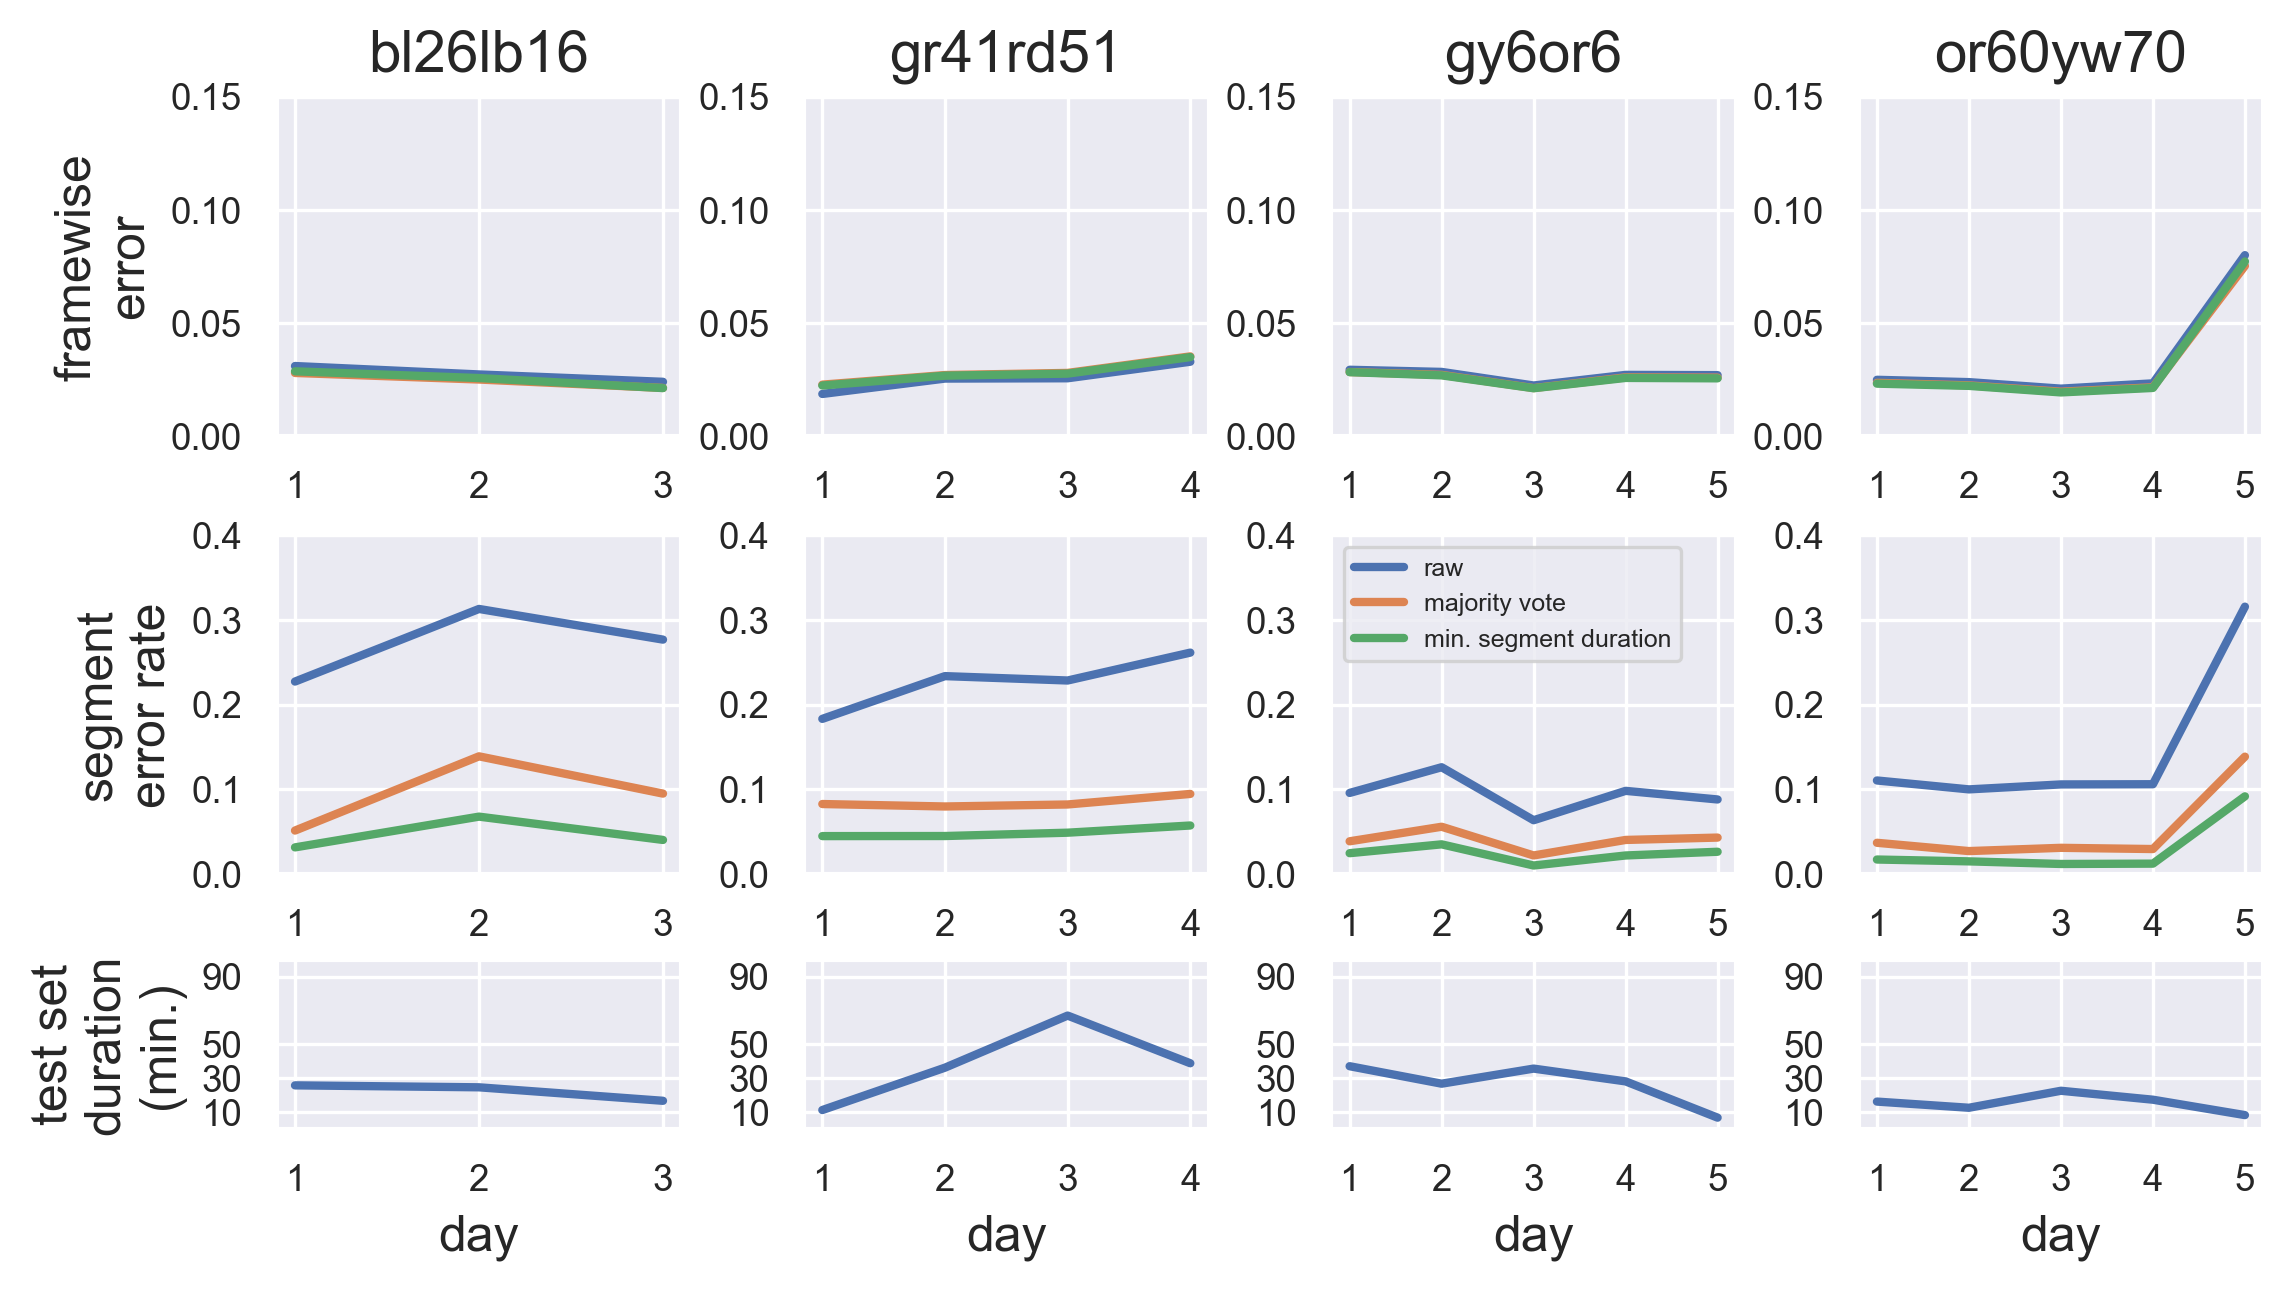

In [12]:
SAVE_FIG = False

sns.set("paper")

bird_ids = data['bird_id'].unique()
n_bird_ids = len(bird_ids)

# only show metrics for days up to and including MAX_DAY
MAX_DAY = 6

ERR_METRICS = [
         'err',
         'err_majority_vote',
         'err_min_segment_dur',
]

SEG_ERR_RATE_METRICS = [
         'segment_error_rate',
         'segment_error_rate_majority_vote',
         'segment_error_rate_min_segment_dur',
]

METRIC_LISTS = (ERR_METRICS, SEG_ERR_RATE_METRICS, ['test_set_duration_min'])

LABEL_PALETTE_MAP = {
    'raw': sns.color_palette("Blues", n_colors=n_bird_ids),
    'majority vote': sns.color_palette("Greens", n_colors=n_bird_ids),
    'min. segment duration': sns.color_palette("Oranges", n_colors=n_bird_ids),
}


nrows, ncols = len(METRIC_LISTS), n_bird_ids
FIGSIZE = (7.5, 4.16)
PPI = 300
# fig, ax = plt.subplots(n_row, n_col, figsize=FIGSIZE)

fig = plt.figure(constrained_layout=True, figsize=FIGSIZE, dpi=PPI)
widths = [1, 1, 1, 1]
heights = [1, 1, 0.5]

spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths, height_ratios=heights)
ax = []
for row, height in enumerate(heights):
    ax_col = []
    for col, width in enumerate(widths):
        ax_col.append(
            fig.add_subplot(spec[row, col])
        )
    ax.append(ax_col)
ax = np.array(ax)

for row, metric_list in enumerate(METRIC_LISTS):
    for col, bird_id in enumerate(bird_ids):
        for metric in metric_list:
            if metric.endswith('majority_vote'):
                label = 'majority vote'
            elif metric.endswith('min_dur_maj_vote'):
                label = 'min. segment duration +\nmajority vote'
            elif metric.endswith('min_segment_dur'):
                label = 'min. segment duration'
            else:
                label = 'raw'

            bird_data = data[(data['bird_id'] == bird_id) & (data['day'] <= MAX_DAY)]

            if metric != 'test_set_duration_min':
                y_name = f'mean_{metric}'
            else:
                y_name = metric

            sns.lineplot(x='day', y=y_name, data=bird_data, ci=None, 
                         palette=LABEL_PALETTE_MAP[label], linewidth=2,
                         label=label, legend=False, ax=ax[row, col])
            ax[row, col].set_ylabel('')
            ax[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))

            if row == 0: 
                ax[row, col].set_title(bird_id, fontsize=14)
                ax[row, col].set_xlabel('')
            elif row == 1:
                ax[row, col].set_xlabel('')
            elif row == 2:
                ax[row, col].set_xlabel('day', fontsize=12)
            
for ax_ in ax[0]:
    ax_.set_ylim([0., 0.15])
for ax_ in ax[1]:
    ax_.set_ylim([0., 0.4])
for ax_ in ax[2]:
    ax_.set_ylim([0., 100])
    ax_.set_yticks([10, 30, 50, 90])
    
ax[0, 0].set_ylabel('framewise\nerror', fontsize=12)
ax[1, 0].set_ylabel('segment\nerror rate', fontsize=12)
ax[2, 0].set_ylabel('test set\nduration\n(min.)', fontsize=12)

# ax[0, 0].legend(loc='upper left', fontsize=8)
ax[1, 2].legend(loc='upper left', fontsize=6);

fig.set_constrained_layout_pads(w_pad=2./72., h_pad=2./72., hspace=0., wspace=0.)

if SAVE_FIG:
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig5/fig5-error-across-days.png')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig5/fig5-error-across-days.svg')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig5/fig5-error-across-days.tiff')
    )